In [37]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)

# Which factors influence the likelihood of forest fires occurring in the Algerian regions?

In the Algerian regions(Northern Africa) of Bejaia and Sidi Bel-abbes during the period, between June 2012 and September 2012, forest fires ravaged an estimated 20,000 hectares of land. 
Our project aims to construct a prediction model for forest fires and we will be using the Algerian Forest Fires Dataset.

**Brief explanation**
* Temperature: Degree Celsius
* RH: Relative Humidity (%)
* Ws: Wind speed (km/h)
* ISI (Initial Spread Index): estimation of the anticipated spread of a fire that is based on FFMC. 
* FFMC (fine fuel moisture code): the moisture content based on litter or other fine fuels. 
* DMC (Duff Moisture Code) and DC (Drought Code): is the average rating of moisture in the organic layers of the forest.
* BUI (Buildup Index): the total amount of fuel that can be used for a combustion reaction, this number is based on the DMC and the DC. 
* FWI (Fire Weather Index): the rating of the strength of the fire.



In [38]:
forestfire_data <- read_csv("Algerian_forest_fires_dataset_UPDATE.csv", skip = 1, 
                            col_types = "ncnnnnnnnnnnnf")%>%
                mutate(month = case_when(month == '06' ~ "June",
                                   month == '07' ~ "Jul",
                                   month == '08' ~ "Aug",
                                   month == '09' ~ "Sep"))%>%
                filter(Classes != 'Classes')

Warning message:
“16 parsing failures.
row         col   expected      actual                                       file
123 day         a number   -           'Algerian_forest_fires_dataset_UPDATE.csv'
123 NA          14 columns 1 columns   'Algerian_forest_fires_dataset_UPDATE.csv'
124 day         a number   day         'Algerian_forest_fires_dataset_UPDATE.csv'
124 year        a number   year        'Algerian_forest_fires_dataset_UPDATE.csv'
124 Temperature a number   Temperature 'Algerian_forest_fires_dataset_UPDATE.csv'
... ........... .......... ........... ..........................................
See problems(...) for more details.
”


**To tidy the dataset, we gave appropriate column types for the variables, the ‘Classes’ column was filtered out due to some rows of NA data.**

[1] 243

`summarise()` ungrouping output (override with `.groups` argument)



Classes,n
<fct>,<int>
not fire,106
fire,137


`summarise()` regrouping output by 'month' (override with `.groups` argument)



month,Classes,FWI
<chr>,<fct>,<dbl>
Sep,not fire,0.6540541
June,not fire,0.6942857
Jul,not fire,1.3739130
Aug,not fire,2.0090909
June,fire,8.6600000
Sep,fire,8.7086957
Jul,fire,10.4394737
Aug,fire,15.5666667


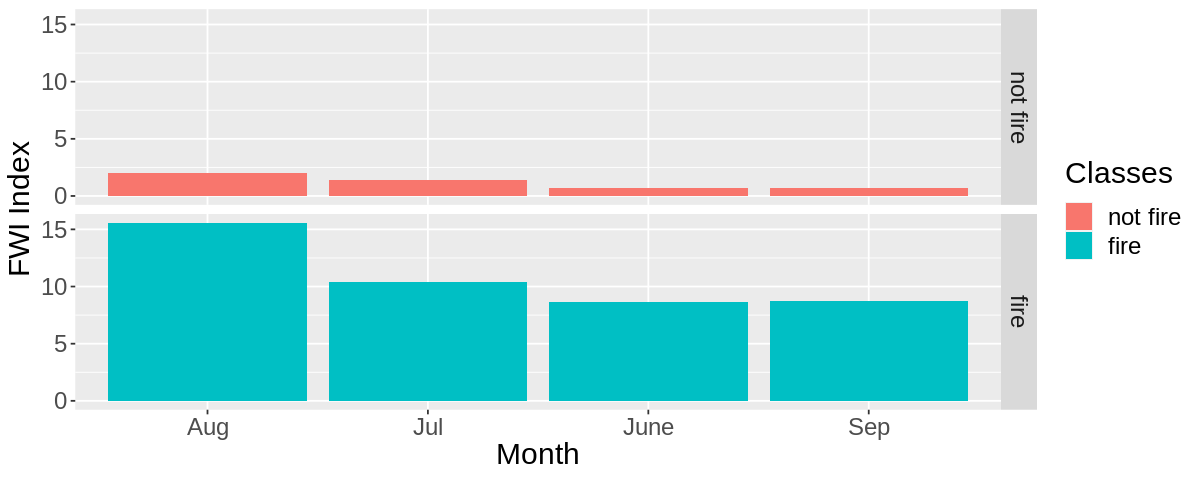

In [47]:
#1
nrow(forestfire_data)

#2
cases_count <- forestfire_data %>%
                group_by(Classes) %>%
                summarize(n = n())
cases_count

#3
FWI_in_month <- forestfire_data %>%
            select(FWI, Classes, month) %>%
            group_by(month, Classes)%>%
            summarize(FWI = mean(FWI)) %>%
            arrange(FWI)
FWI_in_month

FWI_in_month_plot <- FWI_in_month %>%
                    ggplot(aes(x = month, y = FWI, fill = Classes))+
                    geom_bar(stat = "identity")+
                    facet_grid(Classes~.)+
                    labs(x = "Month", y = "FWI Index", fill = "Classes")+
                    theme(text = element_text(size = 18))
FWI_in_month_plot
            

**Exploratory Step**

Firstly, we explored the data to see its size and the amount under each class. We made a plot of FWI values evaluating whether a fire class always has a higher FWI value than a non-fire class.

This is a small dataset and we decided to slice the data with 76% (about 200 cases) for the training set and 24% for the testing set. This will ensure that the training set is large enough while still having sufficient data for the testing set to test the accuracy

We'll use different variables to create scatter plots to visualize the relationships between the vectors.


In [40]:
set.seed(10)

forest_split <- initial_split(forestfire_data, prop = 0.76, strata = Classes)
frst_fire_train <- training(forest_split)
frst_fire_test <- testing(forest_split)

In [41]:

basic_data <- frst_fire_train %>%
                select(month, Temperature:Rain, Classes)
head(basic_data)

FWI_data <- frst_fire_train %>%
                select(month, FWI, Classes)
head(FWI_data)

month,Temperature,RH,Ws,Rain,Classes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
June,29,57,18,0.0,not fire
June,29,61,13,1.3,not fire
June,26,82,22,13.1,not fire
June,25,89,13,2.5,not fire
June,27,77,16,0.0,not fire
June,31,67,14,0.0,fire


month,FWI,Classes
<chr>,<dbl>,<fct>
June,0.5,not fire
June,0.4,not fire
June,0.1,not fire
June,0.0,not fire
June,0.5,not fire
June,2.5,fire


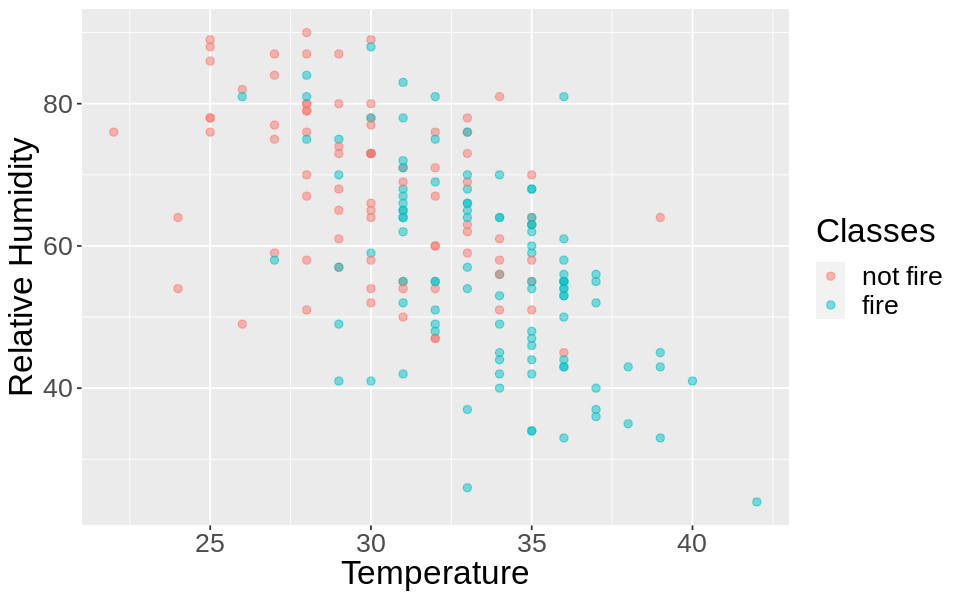

In [42]:
options(repr.plot.width = 8, repr.plot.height = 5)

temp_ws <- frst_fire_train %>%
            ggplot(aes(x = Temperature, y = RH, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Temperature",y = "Relative Humidity", color = "Classes")+
            theme(text = element_text(size = 20))

temp_ws

**The plot shows a moderately strong linear relationship. Fires become more likely to occur as temperatures increase and relative humidity decreases. It can be seen that fires predominantly occur when temperatures are above thirty degrees Celsius and relative humidity is less than 70.**

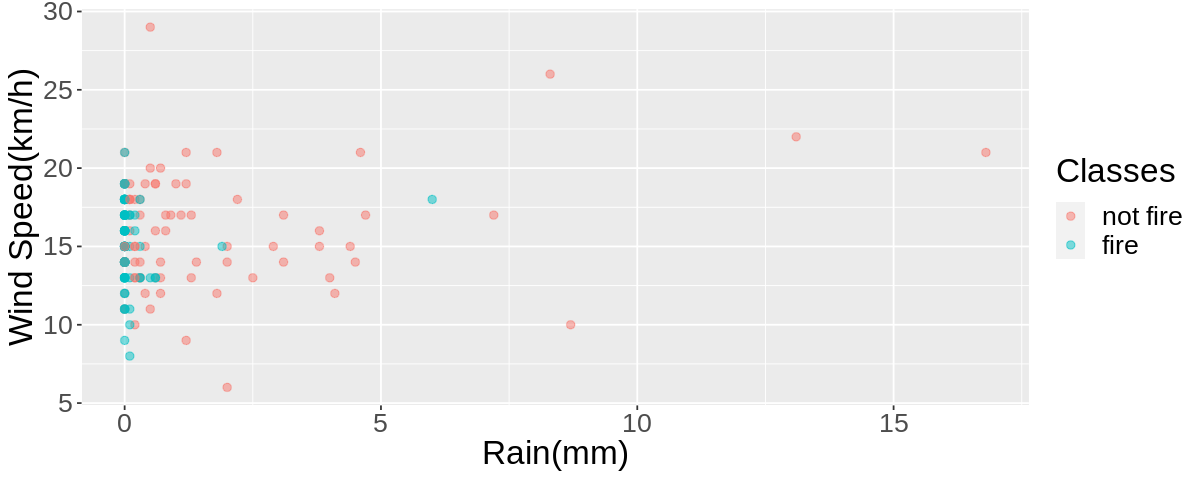

In [43]:
options(repr.plot.width = 10, repr.plot.height = 4)

rain_ws_1 <- frst_fire_train %>%
            ggplot(aes(x = Rain, y = Ws, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Rain(mm)",y = "Wind Speed(km/h)", color = "Classes")+
            theme(text = element_text(size = 20))
rain_ws_1


**From this plot, we realized the dataset needs to be scaled and centred.**

In [44]:
fire_s_train <- frst_fire_train %>%
                        mutate(Temperature = scale(Temperature, center = TRUE),
                              RH = scale(RH, center = TRUE),
                              Ws = scale(Ws, center = TRUE),
                              Rain = scale(Rain, center = TRUE))


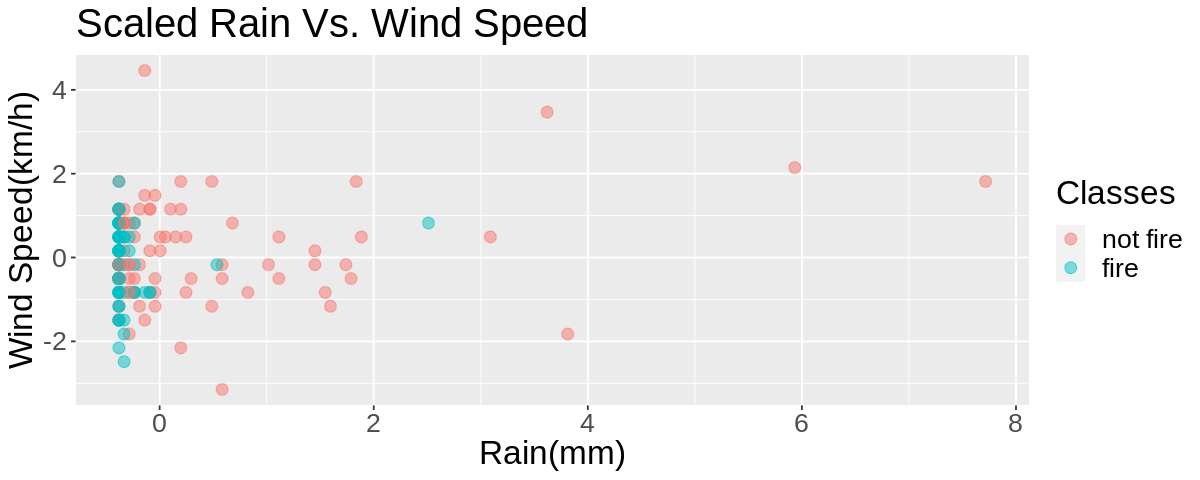

In [46]:
options(repr.plot.width = 10, repr.plot.height = 4)

scaled_rain_ws <- fire_s_train %>%
            ggplot(aes(x = Rain, y = Ws, color = Classes))+
            geom_point(size = 3, alpha = 0.5)+
            labs(x = "Rain(mm)",y = "Wind Speed(km/h)", color = "Classes")+
            theme(text = element_text(size = 20))+
            ggtitle("Scaled Rain Vs. Wind Speed")
scaled_rain_ws

**Method**

We will firstly choose a K-nearest neighbour by visualizing the accuracy estimation to the number of neighbours and then use it to construct a classification model.
The original data set has been split into a training dataset (to fit the model) and a testing dataset (to evaluate the model). To further split the training dataset, we will use cross-validation with C = 5, which would ensure that the data will not be under fitted or overfit, and each observation will only be used once in a validation set.


**Expected outcomes and significance**

We expect to find that the model could predict future forest fires with an accuracy above 75%. This result can be applied to proactive methods to prevent and detect fire signals. We can think of further inquiries such as, does the model fit for other regions in this country, and what about other countries?
